## HW3: Decision Tree, AdaBoost and Random Forest
In hw3, you need to implement decision tree, adaboost and random forest by using only numpy, then train your implemented model by the provided dataset. TA will use the on-hold test label to evaluate your model performance.

Please note that only **NUMPY** can be used to implement your model, you will get no points by simply calling `sklearn.tree.DecisionTreeClassifier`

In [2]:
import pandas as pd
import numpy as np
from numpy import log2
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import random

## class Node

In [3]:
class Node():
    def __init__(self, X: np.ndarray,
                 Y: np.ndarray,
                 depth, criterion='gini',
                 max_depth=None,
                 sample_weight=None,
                 max_features=None):
        """
            X(np arr): features
            Y(np arr): labels
        """
        self.right, self.left=None, None
        self.X, self.Y = X, Y
        self.depth = depth
        self.criterion = criterion
        self.max_depth = max_depth
        self.best_feature, self.best_split_value = None, None
        self.cls = None
        self.is_leaf = False
        self.sample_weight = sample_weight
        self.max_features = max_features

    def gini(self, Y):
        if len(Y) == 0:
            return 0
        if np.unique(Y).shape[0] == 1:  # pure
            return 0

        hist = np.bincount(Y) / len(Y)
        return 1 - np.sum(hist ** 2)

    def entropy(self, Y):
        if len(Y) == 0:
            return 0
        if np.unique(Y).shape[0] == 1:
            return 0

        hist = np.bincount(Y) / len(Y)
        hist = hist[hist != 0]  # eliminate zeros
        return - np.sum(hist * log2(hist))

    def weighted_gini(self, Y_r, Y_l):
        """ weighted sum (gini) """
        return (len(Y_r) * self.gini(Y_r) + len(Y_l) * self.gini(Y_l)) / (len(Y_r) + len(Y_l))

    def weighted_entropy(self, Y_r, Y_l):
        """ weighted sum (entropy) """
        return (len(Y_r) * self.entropy(Y_r) + len(Y_l) * self.entropy(Y_l)) / (len(Y_r) + len(Y_l))

    def sample_weight_gini(self, Y: np.ndarray, sample_weight: np.ndarray):
        cls_list = np.unique(Y)

        if len(Y) == 0:
            return 0
        if len(cls_list) == 1:  # pure
            return 0

        cls_count = np.zeros(len(cls_list))

        for cls in cls_list:
            cls_count[cls] = sample_weight[Y == cls].sum()

        hist = cls_count / sample_weight.sum()  # normalize
        return 1 - np.sum(hist ** 2)

    def sw_gini(self, Y_r, Y_l, sw_r, sw_l):
        """  sample weighted  """
        def gini(Y, sample_weight): return self.sample_weight_gini(
            Y, sample_weight)
        len_r, len_l = sw_r.sum(), sw_l.sum()
        len_tot = len_r + len_l
        return (len_r * gini(Y_r, sw_r) + len_l * gini(Y_l, sw_l)) / len_tot

    def sample_weight_entropy(self, Y: np.ndarray, sample_weight: np.ndarray):
        cls_list = np.unique(Y)

        if len(Y) == 0:
            return 0
        if len(cls_list) == 1:  # pure
            return 0

        cls_count = np.zeros(len(cls_list))

        for cls in cls_list:
            cls_count[cls] = sample_weight[Y == cls].sum()

        hist = cls_count / sample_weight.sum()  # normalize
        hist = hist[hist != 0]  # eliminate zeros
        return - np.sum(hist * log2(hist))

    def sw_entropy(self, Y_r, Y_l, sw_r, sw_l):
        """  sample weighted  """
        def entropy(Y, sample_weight): return self.sample_weight_entropy(
            Y, sample_weight)
        len_r, len_l = sw_r.sum(), sw_l.sum()
        len_tot = len_r + len_l
        return (len_r * entropy(Y_r, sw_r) + len_l * entropy(Y_l, sw_l)) / len_tot

    def sw_best_split(self):
        """ (w/ sample weight) find the best split """
        X, Y, sample_weight = self.X.copy(), self.Y.copy(), self.sample_weight.copy()

        min_gini = float('inf')

        best_feature, best_split_value = 0, 0

        for feature in range(len(X[0])):
            feature_val = np.unique(X[:, feature])

            # skip this feature: no information
            if len(feature_val) == 1:
                continue

            # TODO: categorical features (after one-hot-encoding)
            #   value = 0 or 1
            if np.array_equal(feature_val, [0.0, 1.0]):
                # split
                mask = (X[:, feature] == 0)
                inv_mask = (mask == False)
                Y_l, sw_l = Y[mask], sample_weight[mask]
                Y_r, sw_r = Y[inv_mask], sample_weight[inv_mask]

                Gini = self.sw_entropy(Y_r, Y_l, sw_r, sw_l)
                # print('feature:', feature,  'gini:',Gini)  #FIXME
                if Gini < min_gini:
                    min_gini = Gini
                    best_feature, best_split_value = feature, 0

            # TODO: continuous features
            else:
                # sort by current feature
                idx = np.argsort(X[:, feature])
                X, Y, sample_weight = X[idx], Y[idx], sample_weight[idx]

                # test different split point
                for threshold in feature_val[: -1]:
                    # split
                    mask = (X[:, feature] <= threshold)
                    inv_mask = (mask == False)
                    Y_l, sw_l = Y[mask], sample_weight[mask]
                    Y_r, sw_r = Y[inv_mask], sample_weight[inv_mask]

                    Gini = self.sw_entropy(Y_r, Y_l, sw_r, sw_l)
                    # print('feature:', feature,  'gini:',Gini)  #FIXME
                    if Gini < min_gini:
                        min_gini = Gini
                        best_feature, best_split_value = feature, threshold

        return best_feature, best_split_value

    def sw_split(self):
        """ (w/ sample weight) split this node recursively """
        cls_count = np.bincount(self.Y, minlength=2)

        # make leaf node: reach depth limit or pure node
        if (self.max_depth is not None and self.depth == self.max_depth) or cls_count[0] == 0 or \
                cls_count[1] == 0:
            self.cls = np.argmax(cls_count)  # majority class
            self.is_leaf = True
            return

        # find best split
        best_feature, best_split_value = self.sw_best_split()
        self.best_feature, self.best_split_value = best_feature, best_split_value

        # split data
        # ex: 0, 1; <=50 , >50;
        mask_l = (self.X[:, best_feature] <= best_split_value)
        mask_r = (mask_l == False)
        X_l, Y_l, sw_l = self.X[mask_l,
                                :], self.Y[mask_l], self.sample_weight[mask_l]
        X_r, Y_r, sw_r = self.X[mask_r,
                                :], self.Y[mask_r], self.sample_weight[mask_r]

        lnode = Node(X_l, Y_l, self.depth + 1,
                     self.criterion, self.max_depth, sw_l)
        rnode = Node(X_r, Y_r, self.depth + 1,
                     self.criterion, self.max_depth, sw_r)

        # recursively split children
        self.right, self.left = rnode, lnode

        rnode.sw_split()
        lnode.sw_split()

    def rand_best_split(self):
        ''' used by Random Forest '''
        X, Y = self.X.copy(), self.Y.copy()

        min_gini = 0.5
        min_entropy = 1.0

        # randomly sample features
        feature_idx = np.random.choice(
            len(X[0]), size=self.max_features, replace=False)

        best_feature, best_split_value = feature_idx[0], 0

        for feature in feature_idx:
            feature_val = np.unique(X[:, feature])

            # skip this feature: no information
            if len(feature_val) == 1:
                continue

            # TODO: categorical features (after one-hot-encoding)
            #   value = 0 or 1
            if np.array_equal(feature_val, [0.0, 1.0]):
                # split
                Y_l = Y[X[:, feature] == 0]
                Y_r = Y[X[:, feature] == 1]

                if self.criterion == 'gini':
                    Gini = self.weighted_gini(Y_r, Y_l)
                    if Gini < min_gini:
                        min_gini = Gini
                        best_feature, best_split_value = feature, 0
                elif self.criterion == 'entropy':
                    Entropy = self.weighted_entropy(Y_r, Y_l)
                    if Entropy < min_entropy:
                        min_entropy = Entropy
                        best_feature, best_split_value = feature, 0

            # TODO: continuous features
            else:
                # sort by current feature
                idx = np.argsort(X[:, feature])
                X, Y = X[idx], Y[idx]

                # test different split point
                for threshold in feature_val[: -1]:
                    # split
                    Y_l = Y[X[:, feature] <= threshold]
                    Y_r = Y[X[:, feature] > threshold]

                    if self.criterion == 'gini':
                        Gini = self.weighted_gini(Y_r, Y_l)
                        if Gini < min_gini:
                            min_gini = Gini
                            best_feature, best_split_value = feature, threshold
                    elif self.criterion == 'entropy':
                        Entropy = self.weighted_entropy(Y_r, Y_l)
                        if Entropy < min_entropy:
                            min_entropy = Entropy
                            best_feature, best_split_value = feature, threshold

        return best_feature, best_split_value

    def best_split(self):
        """ find the best split """
        X, Y = self.X.copy(), self.Y.copy()

        min_gini = 0.5
        min_entropy = 1.0

        best_feature, best_split_value = None, None

        for feature in range(len(X[0])):
            feature_val = np.unique(X[:, feature])

            # skip this feature: no information
            if len(feature_val) == 1:
                continue

            # TODO: categorical features (after one-hot-encoding)
            #   value = 0 or 1
            if np.array_equal(feature_val, [0.0, 1.0]):
                # split
                Y_l = Y[X[:, feature] == 0]
                Y_r = Y[X[:, feature] == 1]

                if self.criterion == 'gini':
                    Gini = self.weighted_gini(Y_r, Y_l)
                    if Gini < min_gini:
                        min_gini = Gini
                        best_feature, best_split_value = feature, 0
                elif self.criterion == 'entropy':
                    Entropy = self.weighted_entropy(Y_r, Y_l)
                    if Entropy < min_entropy:
                        min_entropy = Entropy
                        best_feature, best_split_value = feature, 0

            # TODO: continuous features
            else:
                # sort by current feature
                idx = np.argsort(X[:, feature])
                X, Y = X[idx], Y[idx]

                # test different split point
                for threshold in feature_val[: -1]:
                    # split
                    Y_l = Y[X[:, feature] <= threshold]
                    Y_r = Y[X[:, feature] > threshold]

                    if self.criterion == 'gini':
                        Gini = self.weighted_gini(Y_r, Y_l)
                        if Gini < min_gini:
                            min_gini = Gini
                            best_feature, best_split_value = feature, threshold
                    elif self.criterion == 'entropy':
                        Entropy = self.weighted_entropy(Y_r, Y_l)
                        if Entropy < min_entropy:
                            min_entropy = Entropy
                            best_feature, best_split_value = feature, threshold

        return best_feature, best_split_value

    def split(self):
        """ split this node recursively """

        cls_count = np.bincount(self.Y, minlength=2)
        # FIXME
        # print('depth:', self.depth)
        # print('cls 0:', cls_count[0])
        # print('cls 1:', cls_count[1])

        # make leaf node: reach depth limit or pure node
        if (self.max_depth is not None and self.depth == self.max_depth) or cls_count[0] == 0 or \
                cls_count[1] == 0:
            self.cls = np.argmax(cls_count)  # majority class
            self.is_leaf = True

            # FIXME
            # print('predicted class:', self.cls)
            # print()
            return

        # find best split
        best_feature, best_split_value = self.best_split() if self.max_features is None \
            else self.rand_best_split()
        self.best_feature, self.best_split_value = best_feature, best_split_value

        # FIXME
        # print('best_feature: ', best_feature, 'best_split_value: ', best_split_value)

        # split data
        # ex: 0, 1; <=50 , >50;
        mask_l = (self.X[:, best_feature] <= best_split_value)
        mask_r = (mask_l == False)
        X_l, Y_l = self.X[mask_l, :], self.Y[mask_l]
        X_r, Y_r = self.X[mask_r, :], self.Y[mask_r]

        lnode = Node(X_l, Y_l, self.depth + 1, self.criterion, self.max_depth)
        rnode = Node(X_r, Y_r, self.depth + 1, self.criterion, self.max_depth)

        # recursively split children
        self.right, self.left = rnode, lnode
        # print()

        rnode.split()
        lnode.split()

## class DecisionTree

In [4]:
class DecisionTree():
    def __init__(self, criterion='gini', max_depth=None):
        if criterion not in ['gini', 'entropy']:
            raise Exception("supported criterion: 'gini' or 'entropy'")

        self.criterion = criterion
        self.max_depth = max_depth
        self.root = None

    def fit(self, X: np.ndarray, Y: np.ndarray, sample_weight=None, max_features=None):
        """ Build a decision tree classifier from the training set (X, y)."""
        self.X, self.Y = X.copy(), Y.copy()
        self.root = Node(self.X,
                         self.Y,
                         depth=0,
                         criterion=self.criterion,
                         max_depth=self.max_depth,
                         sample_weight=sample_weight,
                         max_features=max_features)

        if sample_weight is None:
            self.root.split()
        else:
            self.root.sw_split()

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """ Predict class value for X. """
        y_pred = []

        for row in X_test:
            cur_node = self.root

            while not cur_node.is_leaf:
                bf = cur_node.best_feature
                cur_node = cur_node.left if row[bf] <= cur_node.best_split_value else cur_node.right

            y_pred.append(cur_node.cls)

        return np.array(y_pred)

    def feature_importance(self) -> np.ndarray:
        """ count occurrence of each best_feature """
        cur_node = self.root

        self.feature_count = np.zeros(len(self.X[0]), dtype='uint8')
        self.feature_count[cur_node.best_feature] += 1

        self.count_feature_util(cur_node.right)
        self.count_feature_util(cur_node.left)

        return self.feature_count

    def count_feature_util(self, cur_node: Node):
        if cur_node.is_leaf:
            return

        self.feature_count[cur_node.best_feature] += 1
        self.count_feature_util(cur_node.right)
        self.count_feature_util(cur_node.left)

## class Adaboost

In [5]:
class AdaBoost():
    def __init__(self, n_estimators):
        self.n_estimators = n_estimators
        self.weak_clf = []
        self.alphas = []

    def fit(self, X: np.ndarray, Y: np.ndarray, lr=0.5):
        self.alphas = []
        n = self.n_estimators
        max_depth = 1

        self.Y = Y.copy()
        # change label: 0 -> -1
        self.Y[Y == 0] = -1

        data_w = np.ones(len(Y)) / len(Y)

        # train n weak classifiers
        for i in range(n):
            # FIXME:
            # print(i, "th weak clf")

            # Fit weak classifier
            clf = DecisionTree(criterion='entropy', max_depth=max_depth)
            # clf = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
            clf.fit(X, Y, sample_weight=data_w)
            y_pred = clf.predict(X)
            y_pred[y_pred == 0] = -1

            # error of the clf prediction
            error = data_w[self.Y != y_pred].sum()
            # print(error)

            # handle boundaries
            if error >= 0.5:
                break
                # alpha = -10.0
            elif error <= 0.0:
                alpha = 10.0
            else:
                alpha = lr * np.log((1 - error) / error)

            self.weak_clf.append(clf)
            # alpha: weight of classifier
            self.alphas.append(alpha)

            #  Update data weights
            data_w = data_w * np.exp(- 1.0 * alpha * self.Y * y_pred)
            data_w = data_w / data_w.sum()

            # FIXME
            # print("error: ", error)
            # print("alpha: ", alpha)
            # print()

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        prediction = np.zeros(len(X_test))
        for i in range(len(self.weak_clf)):
            # if self.alphas[i] > 0:
            y_pred = self.weak_clf[i].predict(X_test)
            y_pred[y_pred == 0] = -1
            prediction += self.alphas[i] * y_pred

        prediction = np.sign(prediction)
        prediction[prediction < 0] = 0
        return prediction

In [6]:
error = 0.0001
error = 0.9999
# error = 0.6
1 / 2 * np.log((1 - error) / error)

-4.60512018348798

## class Random Forest

In [7]:
class RandomForest():
    def __init__(self,
                 n_estimators,
                 max_features,
                 boostrap=True,
                 criterion='gini',
                 max_depth=None):
        self.n_estimators = n_estimators
        self.max_features = int(max_features)
        self.boostrap = boostrap
        self.criterion = criterion
        self.max_depth = max_depth
        self.weak_clf = []

    def fit(self, X: np.ndarray, Y: np.ndarray):
        for i in range(self.n_estimators):
            # bootstrapping
            if self.boostrap:
                sample_idx = np.random.choice(
                    len(X), size=len(X), replace=True)
            else:
                sample_idx = np.arange(len(X))

            clf = DecisionTree(criterion=self.criterion,
                               max_depth=self.max_depth)
            clf.fit(X[sample_idx], Y[sample_idx],
                    max_features=self.max_features)
            self.weak_clf.append(clf)

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        y_pred = np.zeros(len(X_test), dtype='int64')
        for i in range(len(self.weak_clf)):
            y_pred += self.weak_clf[i].predict(X_test)

        mask = (y_pred > (self.n_estimators / 2))
        y_pred[mask] = 1
        y_pred[(mask == False)] = 0
        return y_pred

## class other model

In [8]:
class Node_Pro():
    def __init__(self,
                 X: np.ndarray,
                 Y: np.ndarray,
                 depth,
                 criterion='gini',
                 max_depth=None,
                 max_features=None,
                 init_seed=None):
        """
            X(np arr): features
            Y(np arr): labels
        """
        self.right, self.left = None, None
        self.X, self.Y = X, Y
        self.depth = depth
        self.criterion = criterion
        self.max_depth = max_depth
        self.best_feature, self.best_split_value = None, None
        self.cls = None
        self.is_leaf = False
        self.max_features = int(max_features)
        self.init_seed = init_seed

    def gini(self, Y):
        if len(Y) == 0:
            return 0
        if np.unique(Y).shape[0] == 1:  # pure
            return 0

        hist = np.bincount(Y) / len(Y)
        return 1 - np.sum(hist ** 2)

    def entropy(self, Y):
        if len(Y) == 0:
            return 0
        if np.unique(Y).shape[0] == 1:
            return 0

        hist = np.bincount(Y) / len(Y)
        hist = hist[hist != 0]  # eliminate zeros
        return - np.sum(hist * log2(hist))

    def weighted_gini(self, Y_r, Y_l):
        """ weighted sum (gini) """
        return (len(Y_r) * self.gini(Y_r) + len(Y_l) * self.gini(Y_l)) / (len(Y_r) + len(Y_l))

    def weighted_entropy(self, Y_r, Y_l):
        """ weighted sum (entropy) """
        return (len(Y_r) * self.entropy(Y_r) + len(Y_l) * self.entropy(Y_l)) / (len(Y_r) + len(Y_l))

    def rand_best_split(self):
        ''' 
            sample a subset of features
            used by Random forest 
        '''
        X, Y = self.X.copy(), self.Y.copy()

        min_gini = 0.5
        min_entropy = 1.0

        # randomly sample features
        np.random.seed(self.init_seed)
        feature_idx = np.random.choice(
            len(X[0]), size=self.max_features, replace=False)

        best_feature, best_split_value = feature_idx[0], 0

        for feature in feature_idx:
            feature_val = np.unique(X[:, feature])

            # skip this feature: no information
            if len(feature_val) == 1:
                continue

            # TODO: categorical features (after one-hot-encoding)
            #   value = 0 or 1
            if np.array_equal(feature_val, [0.0, 1.0]):
                # split
                Y_l = Y[X[:, feature] == 0]
                Y_r = Y[X[:, feature] == 1]

                if self.criterion == 'gini':
                    Gini = self.weighted_gini(Y_r, Y_l)
                    if Gini <= min_gini:
                        min_gini = Gini
                        best_feature, best_split_value = feature, 0

                elif self.criterion == 'entropy':
                    Entropy = self.weighted_entropy(Y_r, Y_l)
                    if Entropy <= min_entropy:
                        min_entropy = Entropy
                        best_feature, best_split_value = feature, 0

            # TODO: continuous features
            else:
                # sort by current feature
                idx = np.argsort(X[:, feature])
                X, Y = X[idx], Y[idx]

                # test different split point
                for threshold in feature_val[: -1]:
                    # split
                    Y_l = Y[X[:, feature] <= threshold]
                    Y_r = Y[X[:, feature] > threshold]

                    if self.criterion == 'gini':
                        Gini = self.weighted_gini(Y_r, Y_l)
                        if Gini <= min_gini:
                            min_gini = Gini
                            best_feature, best_split_value = feature, threshold

                    elif self.criterion == 'entropy':
                        Entropy = self.weighted_entropy(Y_r, Y_l)
                        if Entropy <= min_entropy:
                            min_entropy = Entropy
                            best_feature, best_split_value = feature, threshold

        return best_feature, best_split_value

    def split(self):
        """ split this node recursively """

        cls_count = np.bincount(self.Y, minlength=2)
        # FIXME
        # print('depth:', self.depth)
        # print('cls 0:', cls_count[0])
        # print('cls 1:', cls_count[1])

        # make leaf node: reach depth limit or pure node
        if (self.max_depth is not None and self.depth == self.max_depth) or cls_count[0] == 0 or \
                cls_count[1] == 0:
            self.cls = np.argmax(cls_count)  # majority class
            self.is_leaf = True

            # FIXME
            # print('predicted class:', self.cls)
            # print()
            return

        # find best split
        best_feature, best_split_value = self.rand_best_split()
        self.best_feature, self.best_split_value = best_feature, best_split_value

        # FIXME
        # print('best_feature: ', best_feature, 'best_split_value: ', best_split_value)

        # split data
        # ex: 0, 1; <=50 , >50;
        mask_l = (self.X[:, best_feature] <= best_split_value)
        mask_r = (mask_l == False)
        X_l, Y_l = self.X[mask_l, :], self.Y[mask_l]
        X_r, Y_r = self.X[mask_r, :], self.Y[mask_r]

        lnode = Node_Pro(X_l, Y_l, self.depth + 1, self.criterion,
                         self.max_depth, self.max_features, (2*self.init_seed) % 10000000)
        rnode = Node_Pro(X_r, Y_r, self.depth + 1, self.criterion,
                         self.max_depth, self.max_features, 2*self.init_seed+1 % 10000000)

        # recursively split children
        self.right, self.left = rnode, lnode
        # print()

        rnode.split()
        lnode.split()


class DecisionTree_Pro():
    def __init__(self, criterion='gini', max_depth=None):
        if criterion not in ['gini', 'entropy']:
            raise Exception("supported criterion: 'gini' or 'entropy'")

        self.criterion = criterion
        self.max_depth = max_depth
        self.root = None

    def fit(self, X: np.ndarray, Y: np.ndarray, max_features=None, init_seed=None):
        """ Build a decision tree classifier from the training set (X, y)."""
        self.X, self.Y = X.copy(), Y.copy()
        self.root = Node_Pro(self.X,
                             self.Y,
                             depth=0,
                             criterion=self.criterion,
                             max_depth=self.max_depth,
                             max_features=max_features, init_seed=init_seed)

        self.root.split()

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        """ Predict class value for X. """
        y_pred = []

        for row in X_test:
            cur_node = self.root

            while not cur_node.is_leaf:
                bf = cur_node.best_feature
                cur_node = cur_node.left if row[bf] <= cur_node.best_split_value else cur_node.right

            y_pred.append(cur_node.cls)

        return np.array(y_pred)

    def feature_importance(self) -> np.ndarray:
        """ count occurrence of each best_feature """
        cur_node = self.root

        self.feature_count = np.zeros(len(self.X[0]), dtype='uint8')
        self.feature_count[cur_node.best_feature] += 1

        self.count_feature_util(cur_node.right)
        self.count_feature_util(cur_node.left)

        return self.feature_count

    def count_feature_util(self, cur_node):
        if cur_node.is_leaf:
            return

        self.feature_count[cur_node.best_feature] += 1
        self.count_feature_util(cur_node.right)
        self.count_feature_util(cur_node.left)


class RandomForest_Pro():
    def __init__(self,
                 n_estimators,
                 max_features,
                 boostrap=True,
                 criterion='gini',
                 max_depth=None):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.boostrap = boostrap
        self.criterion = criterion
        self.max_depth = max_depth
        self.weak_clf = []

    def fit(self, X: np.ndarray, Y: np.ndarray, seeds):
        for i in range(self.n_estimators):
            # bootstrapping
            if self.boostrap:
                np.random.seed(seeds[i])
                sample_idx = np.random.choice(
                    len(X), size=len(X), replace=True)
            else:
                sample_idx = np.arange(len(X))

            clf = DecisionTree_Pro(
                criterion=self.criterion, max_depth=self.max_depth)
            clf.fit(X[sample_idx], Y[sample_idx],
                    max_features=self.max_features, init_seed=seeds[i])

            y_pred = clf.predict(X)

            # print('     ', accuracy_score(Y, y_pred))
            if 0.9 < accuracy_score(Y, y_pred):
                self.weak_clf.append(clf)
                # print(clf.feature_importance())
            # self.weak_clf.append(clf)

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        y_pred = np.zeros(len(X_test), dtype='int64')
        for i in range(len(self.weak_clf)):
            y_pred += self.weak_clf[i].predict(X_test)

        mask = (y_pred > (len(self.weak_clf) // 2))
        y_pred[mask] = 1
        y_pred[(mask == False)] = 0
        return y_pred

## Question 1
Gini Index or Entropy is often used for measuring the “best” splitting of the data. Please compute the Entropy and Gini Index of provided data. Please use the formula from [page 5 of hw3 slides](https://docs.google.com/presentation/d/1kIe_-YZdemRMmr_3xDy-l0OS2EcLgDH7Uan14tlU5KE/edit#slide=id.gd542a5ff75_0_15)

In [9]:
def gini(sequence):
    if len(sequence) == 0:
        return 0
    if len(np.unique(sequence)) == 1:  # pure
        return 0

    hist = np.bincount(sequence) / len(sequence)

    return 1 - np.sum(hist ** 2)


def entropy(sequence):
    if len(sequence) == 0:
        return 0
    if len(np.unique(sequence)) == 1:  # pure
        return 0

    hist = np.bincount(sequence) / len(sequence)
    hist = hist[hist != 0]  # eliminate zeros (log2)

    return - np.sum(hist * log2(hist))

In [10]:
# 1 = class 1,
# 2 = class 2
data = np.array([1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2])

In [11]:
print("Gini of data is ", gini(data))

Gini of data is  0.4628099173553719


In [12]:
print("Entropy of data is ", entropy(data))

Entropy of data is  0.9456603046006401


## Load data
It is a binary classifiation dataset that classify if price is high or not for a cell phone, the label is stored in `price_range` column.

In [13]:
import pandas as pd

train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')
# train_df = pd.concat([train_df, val_df])
test_df = pd.read_csv('x_test.csv')

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

# train_df.head()
test_df.head()

(1200, 21)
(300, 21)
(500, 20)


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,1076,0,2.5,0,3,0,14,0.2,105,5,4,545,1300,2043,7,5,14,0,0,0
1,759,0,2.5,0,3,1,39,0.3,162,2,8,110,1317,968,6,2,2,1,0,0
2,1562,1,1.3,1,1,1,7,0.2,190,5,15,642,1533,2243,12,10,6,1,0,0
3,1954,0,0.6,1,8,0,7,0.9,126,3,9,673,690,3438,17,12,13,1,0,0
4,1989,0,2.5,1,0,1,41,0.8,94,3,13,1100,1497,1665,17,9,12,1,1,1


In [14]:
# train_df.info()
# test_df.info()
print(train_df.columns)
# print(val_df.columns)
print(test_df.columns)

Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi', 'price_range'],
      dtype='object')
Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi'],
      dtype='object')


In [15]:
features = list(train_df.columns)
features.remove('price_range')


x_train = train_df[features].to_numpy()
y_train = train_df['price_range'].to_numpy()
x_val = val_df[features].to_numpy()
y_val = val_df['price_range'].to_numpy()
x_test = test_df[features].to_numpy()
# y_test = test_df['price_range'].to_numpy()

#### column property


In [16]:
# categorical: 'blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi'
# continous: 'battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time',

In [17]:
col = 'price_range'
tmp = train_df[col].to_numpy()
# print(tmp)
# print(train_df[col].value_counts(sort=False))
print(np.unique(tmp))

[0 1]


## Question 2
Implement the Decision Tree algorithm (CART, Classification and Regression Trees) and trained the model by the given arguments, and print the accuracy score on the validation data. You should implement two arguments for the Decision Tree algorithm
1. **criterion**: The function to measure the quality of a split. Your model should support `gini` for the Gini impurity and `entropy` for the information gain. 
2. **max_depth**: The maximum depth of the tree. If `max_depth=None`, then nodes are expanded until all leaves are pure. `max_depth=1` equals to split data once


### Question 2.1
Using `criterion=gini`, showing the accuracy score of validation data by `max_depth=3` and `max_depth=10`, respectively.


In [18]:
clf_depth3 = DecisionTree(criterion='gini', max_depth=3)
clf_depth3.fit(x_train, y_train)
y_pred = clf_depth3.predict(x_val)
print('Depth = 3')
print('Test-set accuarcy score: ', accuracy_score(y_val, y_pred))

Depth = 3
Test-set accuarcy score:  0.9166666666666666


In [19]:
clf_depth10 = DecisionTree(criterion='gini', max_depth=10)
clf_depth10.fit(x_train, y_train)
y_pred = clf_depth10.predict(x_val)
print('Depth = 10')
print('Test-set accuarcy score: ', accuracy_score(y_val, y_pred))

Depth = 10
Test-set accuarcy score:  0.9366666666666666


### Question 2.2
Using `max_depth=3`, showing the accuracy score of validation data by `criterion=gini` and `criterion=entropy`, respectively.


In [20]:
clf_gini = DecisionTree(criterion='gini', max_depth=3)
clf_gini.fit(x_train, y_train)
y_pred = clf_gini.predict(x_val)
print('Gini')
print('Test-set accuarcy score: ', accuracy_score(y_val, y_pred))

Gini
Test-set accuarcy score:  0.9166666666666666


In [21]:
clf_entropy = DecisionTree(criterion='entropy', max_depth=3)
clf_entropy.fit(x_train, y_train)
y_pred = clf_entropy.predict(x_val)
print('Entropy')
print('Test-set accuarcy score: ', accuracy_score(y_val, y_pred))

Entropy
Test-set accuarcy score:  0.93


- Note: Your decisition tree scores should over **0.9**. It may suffer from overfitting, if so, you can tune the hyperparameter such as `max_depth`
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes


## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the **counts of feature used** for building tree without normalize the importance. Take the figure below as example, outlook feature has been used for splitting for almost 50 times. Therefore, it has the largest importance

![image](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/04/c45-fi-results.jpg?w=481&ssl=1)

In [22]:
features = np.array(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 'm_dep', 'mobile_wt',
                    'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi'])
print(len(features))

20


In [23]:
hist = clf_depth10.feature_importance()
print(hist)

[19  0  0  0  2  0  0  2  1  0  0  9  5  9  0  0  0  0  0  0]


In [24]:
mask_sort = hist.argsort()
print(mask_sort)

[ 9 17 16 15 14 10 18 19  6  5  3  2  1  8  4  7 12 11 13  0]


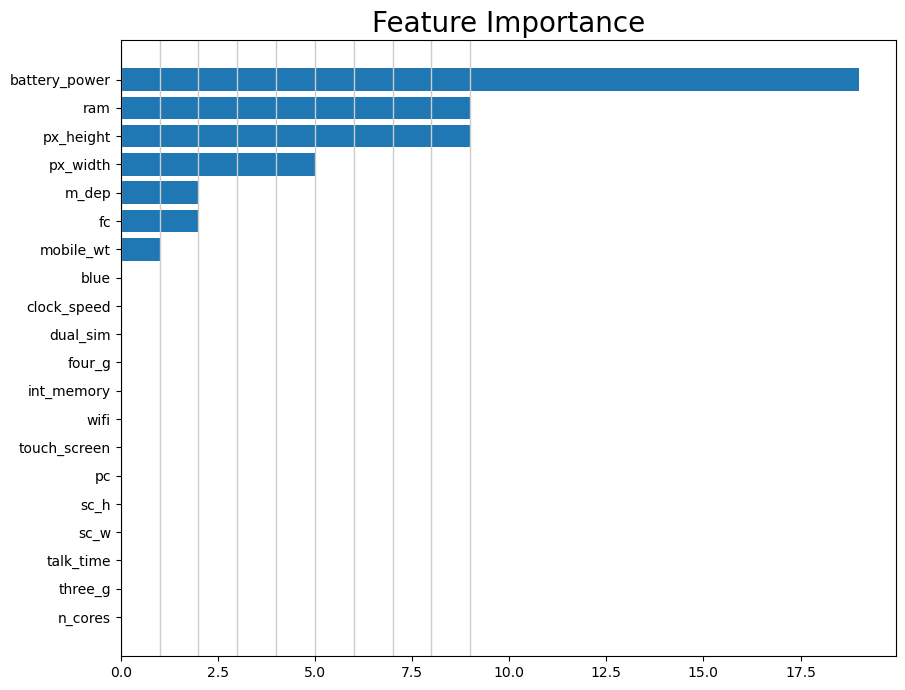

In [25]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Feature Importance', {'fontsize': 20})
ax.barh(features[mask_sort], hist[mask_sort])

for i in range(10):
    ax.axvline(x=i, linewidth=1, color='0.8')

## Question 4
implement the AdaBooest algorithm by using the CART you just implemented from question 2 as base learner. You should implement one arguments for the AdaBooest.
1. **n_estimators**: The maximum number of estimators at which boosting is terminated

In [64]:
# class AdaBoost():
#     def __init__(self, n_estimators):
#         pass

#     def fit(self, x_data, y_data):
#         pass

#     def predict(self, x_data):
#         pass

### Question 4.1
Show the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [26]:
clf_Ada_10 = AdaBoost(n_estimators=10)
clf_Ada_10.fit(x_train, y_train)
y_pred = clf_Ada_10.predict(x_val)
print('n_estimators=10')
print('Test-set accuarcy score: ', accuracy_score(y_val, y_pred))

n_estimators=10
Test-set accuarcy score:  0.94


In [27]:
clf_Ada_100 = AdaBoost(n_estimators=100)
clf_Ada_100.fit(x_train, y_train)
y_pred = clf_Ada_100.predict(x_val)
print('n_estimators=100')
print('Test-set accuarcy score: ', accuracy_score(y_val, y_pred))

n_estimators=100
Test-set accuarcy score:  0.9766666666666667


## Question 5
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement three arguments for the Random Forest.

1. **n_estimators**: The number of trees in the forest. 
2. **max_features**: The number of random select features to consider when looking for the best split
3. **bootstrap**: Whether bootstrap samples are used when building tree


In [67]:
# class RandomForest():
#     def __init__(self, n_estimators, max_features, boostrap=True, criterion='gini', max_depth=None):
#         pass

#     def fit(self, x_data, y_data):
#         pass

#     def predict(self, x_data):
#         pass

### Question 5.1
Using `criterion=gini`, `max_depth=None`, `max_features=sqrt(n_features)`, showing the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [28]:
clf_10tree = RandomForest(n_estimators=10, max_features=np.sqrt(
    x_train.shape[1]), boostrap=True, criterion='gini', max_depth=None)
clf_10tree.fit(x_train, y_train)
y_pred = clf_10tree.predict(x_val)
print('n_estimators=10')
print('Test-set accuarcy score: ', accuracy_score(y_val, y_pred))

n_estimators=10
Test-set accuarcy score:  0.9533333333333334


In [29]:
clf_100tree = RandomForest(n_estimators=100, max_features=np.sqrt(
    x_train.shape[1]), boostrap=True, criterion='gini', max_depth=None)
clf_100tree.fit(x_train, y_train)
y_pred = clf_100tree.predict(x_val)
print('n_estimators=100')
print('Test-set accuarcy score: ', accuracy_score(y_val, y_pred))

n_estimators=100
Test-set accuarcy score:  0.9633333333333334


### Question 5.2
Using `criterion=gini`, `max_depth=None`, `n_estimators=10`, showing the accuracy score of validation data by `max_features=sqrt(n_features)` and `max_features=n_features`, respectively.


In [30]:
clf_random_features = RandomForest(n_estimators=10, max_features=np.sqrt(
    x_train.shape[1]), boostrap=True, criterion='gini', max_depth=None)
clf_random_features.fit(x_train, y_train)
y_pred = clf_random_features.predict(x_val)
print('max_features=sqrt(n)')
print('Test-set accuarcy score: ', accuracy_score(y_val, y_pred))

max_features=sqrt(n)
Test-set accuarcy score:  0.95


- Note: Use majority votes to get the final prediction, you may get slightly different results when re-building the random forest model

In [31]:
clf_all_features = RandomForest(
    n_estimators=10, max_features=x_train.shape[1], boostrap=True, criterion='gini', max_depth=None)
clf_all_features.fit(x_train, y_train)
y_pred = clf_all_features.predict(x_val)
print('max_features=n')
print('Test-set accuarcy score: ', accuracy_score(y_val, y_pred))

max_features=n
Test-set accuarcy score:  0.95


## Question 6. Train and tune your model on a real-world dataset
Try you best to get higher accuracy score of your model. After parameter tuning, you can train your model on the full dataset (train + val).
- Feature engineering
- Hyperparameter tuning
- Implement any other ensemble methods, such as gradient boosting. Please note that you **can not** call any package. Also, only ensemble method can be used. Neural network method is not allowed to used.

In [32]:
clf_Ada_100 = AdaBoost(n_estimators=100)
clf_Ada_100.fit(x_train, y_train, lr=0.5)
y_pred = clf_Ada_100.predict(x_val)
print('n_estimators=100')
print('Val-set accuarcy score: ', accuracy_score(y_val, y_pred))

n_estimators=100
Val-set accuarcy score:  0.9766666666666667


In [33]:
# combine train and val data
x_train = np.append(x_train, x_val, axis=0)
y_train = np.append(y_train, y_val, axis=0)

In [35]:
clf_Ada_100 = AdaBoost(n_estimators=100)
clf_Ada_100.fit(x_train, y_train)

In [75]:
y_pred = clf_Ada_100.predict(x_val)
print('n_estimators=100')
print('Val-set accuarcy score: ', accuracy_score(y_val, y_pred))

n_estimators=100
Val-set accuarcy score:  0.9966666666666667


In [76]:
# y_pred: final prediction
y_pred = clf_Ada_100.predict(x_test)

In [38]:
# n = 15
# max_depth = 15
# max_features = 10


# for i in range(100):
#     seeds = np.random.choice(1000, size=n, replace=True)
#     print(f'seeds: {seeds}')

#     clf = RandomForest_Pro(
#         n_estimators=n, max_features=max_features, boostrap=True, max_depth=max_depth)
#     clf.fit(x_train, y_train, seeds)
#     y_pred = clf.predict(x_val)
#     score = accuracy_score(y_val, y_pred)
#     print(f'Test score={score}')

#     if score > 0.975:
#         break

## Supplementary
If you have trouble to implement this homework, TA strongly recommend watching [this video](https://www.youtube.com/watch?v=LDRbO9a6XPU), which explains Decision Tree model clearly. But don't copy code from any resources, try to finish this homework by yourself! 

### DO NOT MODIFY CODE BELOW

In [39]:
import pandas as pd
from sklearn.metrics import accuracy_score
y_test = pd.read_csv('y_test.csv')['price_range'].values

print('Test-set accuarcy score: ', accuracy_score(y_test, y_pred))

FileNotFoundError: [Errno 2] No such file or directory: 'y_test.csv'

In [37]:
def discrete_checker(score, thres, clf, name, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    if accuracy_score(y_test, y_pred) - thres >= 0:
        return score
    else:
        print(f"{name} failed")
        return 0


def patient_checker(score, thres, CLS, kwargs, name,
                    x_train, y_train, x_test, y_test, patient=10):
    while patient > 0:
        patient -= 1
        clf = CLS(**kwargs)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        if accuracy_score(y_test, y_pred) - thres >= 0:
            return score
    print(f"{name} failed")
    print("Considering the randomness, we will check it manually")
    return 0


def load_dataset():
    file_url = "http://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv"
    df = pd.read_csv(
        file_url,
        names=["Length", "Diameter", "Height", "Whole weight", "Shucked weight",
               "Viscera weight", "Shell weight", "Age"]
    )

    df['Target'] = (df["Age"] > 15).astype(int)
    df = df.drop(labels=["Age"], axis="columns")

    train_idx = range(0, len(df), 10)
    test_idx = range(1, len(df), 20)

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

    x_train = train_df.drop(labels=["Target"], axis="columns")
    feature_names = x_train.columns.values
    x_train = x_train.values
    y_train = train_df['Target'].values

    x_test = test_df.drop(labels=["Target"], axis="columns")
    x_test = x_test.values
    y_test = test_df['Target'].values
    return x_train, y_train, x_test, y_test, feature_names


score = 0

data = np.array([1, 2])
if abs(gini(data) - 0.5) < 1e-4:
    score += 2.5
else:
    print("gini test failed")

if abs(entropy(data) - 1) < 1e-4:
    score += 2.5
else:
    print("entropy test failed")

x_train, y_train, x_test, y_test, feature_names = load_dataset()

score += discrete_checker(5, 0.9337,
                          DecisionTree(criterion='gini', max_depth=3),
                          "DecisionTree(criterion='gini', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9036,
                          DecisionTree(criterion='gini', max_depth=10),
                          "DecisionTree(criterion='gini', max_depth=10)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9096,
                          DecisionTree(criterion='entropy', max_depth=3),
                          "DecisionTree(criterion='entropy', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

print("*** We will check your result for Question 3 manually *** (5 points)")

score += patient_checker(
    7.5, 0.91, AdaBoost, {"n_estimators": 10},
    "AdaBoost(n_estimators=10)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    7.5, 0.87, AdaBoost, {"n_estimators": 100},
    "AdaBoost(n_estimators=100)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 10, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=10, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 100, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=100, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.92, RandomForest,
    {"n_estimators": 10, "max_features": x_train.shape[1]},
    "RandomForest(n_estimators=10, max_features=n_features)",
    x_train, y_train, x_test, y_test
)

print("*** We will check your result for Question 6 manually *** (20 points)")
print("Approximate score range:", score, "~", score + 25)
print("*** This score is only for reference ***")

*** We will check your result for Question 3 manually *** (5 points)
*** We will check your result for Question 6 manually *** (20 points)
Approximate score range: 45.0 ~ 70.0
*** This score is only for reference ***


## self-testing

In [42]:
def discrete_checker(score, thres, clf, name, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(f'acc: {accuracy_score(y_test, y_pred)}')
    if accuracy_score(y_test, y_pred) - thres >= 0:
        return score
    else:
        print(f"{name} failed")
        return 0


def patient_checker(score, thres, CLS, kwargs, name,
                    x_train, y_train, x_test, y_test, patient=10):
    while patient > 0:
        patient -= 1
        clf = CLS(**kwargs)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        print(f'acc: {accuracy_score(y_test, y_pred)}')
        if accuracy_score(y_test, y_pred) - thres >= 0:
            return score
    print(f"{name} failed")
    print("Considering the randomness, we will check it manually")
    return 0


def load_dataset():
    file_url = "http://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv"
    df = pd.read_csv(
        file_url,
        names=["Length", "Diameter", "Height", "Whole weight", "Shucked weight",
               "Viscera weight", "Shell weight", "Age"]
    )

    df['Target'] = (df["Age"] > 15).astype(int)
    df = df.drop(labels=["Age"], axis="columns")

    train_idx = range(0, len(df), 10)
    test_idx = range(1, len(df), 20)

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

    x_train = train_df.drop(labels=["Target"], axis="columns")
    feature_names = x_train.columns.values
    x_train = x_train.values
    y_train = train_df['Target'].values

    x_test = test_df.drop(labels=["Target"], axis="columns")
    x_test = x_test.values
    y_test = test_df['Target'].values
    return x_train, y_train, x_test, y_test, feature_names


score = 0

data = np.array([1, 2])
if abs(gini(data) - 0.5) < 1e-4:
    score += 2.5
else:
    print("gini test failed")

if abs(entropy(data) - 1) < 1e-4:
    score += 2.5
else:
    print("entropy test failed")

x_train, y_train, x_test, y_test, feature_names = load_dataset()

print('Testing: DecisionTree(criterion=\'gini\', max_depth=3)')
score += discrete_checker(5, 0.9337,
                          DecisionTree(criterion='gini', max_depth=3),
                          "DecisionTree(criterion='gini', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

print('Testing: DecisionTree(criterion=\'gini\', max_depth=10)')
score += discrete_checker(2.5, 0.9036,
                          DecisionTree(criterion='gini', max_depth=10),
                          "DecisionTree(criterion='gini', max_depth=10)",
                          x_train, y_train, x_test, y_test
                          )

print('Testing: DecisionTree(criterion=\'entropy\', max_depth=3)')
score += discrete_checker(2.5, 0.9096,
                          DecisionTree(criterion='entropy', max_depth=3),
                          "DecisionTree(criterion='entropy', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

print("*** We will check your result for Question 3 manually *** (5 points)")

print('Testing: AdaBoost(n_estimators=10)')
score += patient_checker(
    7.5, 0.91, AdaBoost, {"n_estimators": 10},
    "AdaBoost(n_estimators=10)",
    x_train, y_train, x_test, y_test
)

print('Testing: AdaBoost(n_estimators=100)')
score += patient_checker(
    7.5, 0.87, AdaBoost, {"n_estimators": 100},
    "AdaBoost(n_estimators=100)",
    x_train, y_train, x_test, y_test
)

print('Testing: RandomForest(n_estimators=10, max_features=sqrt(n_features))')
score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 10, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=10, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

print('Testing: RandomForest(n_estimators=100, max_features=sqrt(n_features))')
score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 100, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=100, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

print('Testing: RandomForest(n_estimators=10, max_features=n_features)')
score += patient_checker(
    5, 0.92, RandomForest,
    {"n_estimators": 10, "max_features": x_train.shape[1]},
    "RandomForest(n_estimators=10, max_features=n_features)",
    x_train, y_train, x_test, y_test
)

print("*** We will check your result for Question 6 manually *** (20 points)")
print("Approximate score range:", score, "~", score + 25)
print("*** This score is only for reference ***")

Testing: DecisionTree(criterion='gini', max_depth=3)
acc: 0.9397590361445783
Testing: DecisionTree(criterion='gini', max_depth=10)
acc: 0.9096385542168675
Testing: DecisionTree(criterion='entropy', max_depth=3)
acc: 0.9096385542168675
*** We will check your result for Question 3 manually *** (5 points)
Testing: AdaBoost(n_estimators=10)
acc: 0.9156626506024096
Testing: AdaBoost(n_estimators=100)
acc: 0.9156626506024096
Testing: RandomForest(n_estimators=10, max_features=sqrt(n_features))
acc: 0.9337349397590361
Testing: RandomForest(n_estimators=100, max_features=sqrt(n_features))
acc: 0.927710843373494
Testing: RandomForest(n_estimators=10, max_features=n_features)
acc: 0.9397590361445783
*** We will check your result for Question 6 manually *** (20 points)
Approximate score range: 45.0 ~ 70.0
*** This score is only for reference ***


In [ ]:
# from sklearn.tree import DecisionTreeClassifier

# from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier

# clf = AdaBoostClassifier(DecisionTreeClassifier(criterion = "gini", max_depth=1), n_estimators=10, algorithm="SAMME", learning_rate=1)
# clf = clf.fit(x_train,y_train)
# y_pred = clf.predict(x_test)
# print(f'acc: {accuracy_score(y_test, y_pred)}')
# print(clf.estimator_errors_)
# print(clf.n_classes_)
# print(clf.n_features_in_)

In [ ]:
test_df